# **Projet 6 : Classifiez automatiquement des biens de consommation**

# Notebook 3 : Combinaison du meilleur modèle de texte et d'image et classification supervisée

# Sommaire:

**Objectif**

**<a href="#C1"> I) Fonctions de l'analyse </a>**
- 1) Fonctions de préparation du corpus
- 2) Fonctions de clustering et réduction de dimensions

**<a href="#C5"> II) Génération des features par SBERT</a>**

**<a href="#C9"> III) Génération des features par Inception V3</a>**

**<a href="#C9"> IV) Combinaison des features SBERT et InceptionV3</a>**
- 1) Features bruts
- 2) Features standardisées

**<a href="#C16"> V) Brève classification supervisée</a>**

&nbsp;

***

# **Objectif**

**Contexte :**

L’ entreprise "Place de marché” souhaite lancer une marketplace e-commerce. Pour cela, les vendeurs doivent attribuer une catégorie manuellement à leurs produits à partir d’une description et d’une photo.  Afin de passer à une plus large échelle et faciliter le processus, il devient nécessaire d’automatiser cette tâche.
  
_


**Mission :** 

Réaliser une première étude de faisabilité d'un moteur de classification afin d'attribuer automatiquement la catégorie à un article :
- Analyse de données textuelles (description) + Clustering
- Analyse de données visuelles (image) + Clustering
&nbsp;

_


**Données :**

Export de la base de données contenant 1050 produits, leur description et leur image associées
&nbsp;

_


**Livrables :**

Afin de répondre à cette mission, trois notebook ont été réalisé : 
- Notebook 1 : Analyse des données textuelles (description) et clusterisation
- Notebook 2 : Analyse des données visuelles (images) et clusterisation
- Notebook 3 : Combinaison du meilleur modèle de texte et d'image et classification supervisée

***

In [4]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Import du DF déjà clean

df = pd.read_csv(r"C:\Users\elodi\Documents\DS\Nouveau dossier\data_cleaned.csv")

# <a name="C1"> I) Fonctions de l'analyse

## 1) Fonctions de préparation du corpus

In [8]:
# Affichage des tokens
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk
from tqdm import tqdm

def display_tokens_info(tokens):
    """display token info"""
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:20])


##########################################
##########################################
# Tokenizer


def tokenizer_fct(sentence):
    # print(sentence)
    tokenizer = RegexpTokenizer(r"[a-zA-Z]+")
    word_tokens = tokenizer.tokenize(sentence)
    return word_tokens


##########################################
##########################################

# Stop words
stop_w = list(set(stopwords.words('english')))


def stop_word_filter_fct(list_words):
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

##########################################
##########################################

# lower case et alpha


def lower_start_fct(list_words):
    lw = [w.lower() for w in list_words]
    return lw

##########################################
##########################################


# Lemmatizer (base d'un mot)


def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# stemming


def stemma_fct(list_words):
    stemmer = PorterStemmer()
    stem_w = [stemmer.stem(w) for w in list_words]
    return stem_w

##########################################
##########################################


def lst_non_informative(corpus,
                        stem_or_lem='lem',
                        thres_com=10):
    """basic function of text processing"""
    corpus_raw = "".join(corpus.values)
    word_tokens = tokenizer_fct(corpus_raw)
    lw = lower_start_fct(word_tokens)
    sw = stop_word_filter_fct(lw)

    if stem_or_lem == 'lem':
        trans = lemma_fct(sw)
    else:
        trans = stemma_fct(sw)

    # unique word
    tmp = pd.Series(trans).value_counts()
    list_unique_words = tmp[tmp == 1].reset_index()
    # common words
    list_common_words = tmp.head(thres_com).reset_index()
    # non informative words
    non_informative_words = pd.concat(
        [list_common_words['index'], list_unique_words['index']], ignore_index=True).to_list()

    return non_informative_words


##########################################
##########################################

def no_info_word_filter_fct(list_words, non_info_word):
    filtered_w = [w for w in list_words if not w in non_info_word]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

##########################################
##########################################

# Fonction de préparation du texte pour le bag of words avec lemm or stemming


def transform_bow_fct(desc_text, non_info_word, stem_or_lem='lem', rejoin=True):
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    sw = stop_word_filter_fct(lw)

    if stem_or_lem == 'lem':
        st_lem_w = lemma_fct(sw)
    else:
        st_lem_w = stemma_fct(sw)

    filt = no_info_word_filter_fct(st_lem_w, non_info_word)

    if rejoin:
        return " ".join(filt)

    return filt

## 2) Fonctions de clustering et réduction de dimensions

In [10]:
import time
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import TruncatedSVD
from umap import UMAP
from sklearn.preprocessing import LabelEncoder


def select_n_components(features, goal_var: float) -> int:
    """ 
    La méthode PCA de sklearn permet de selectionner un float en n_compoents afin de ne garder que 0.99 (par ex) de la variance totale mais cela n'est pas possible pour la méthode SVD.
    Cette function permet de récupérer le nombre de composantes expliquant X%  de la variance totale par la méthode de réduction SVD. 
    """

    # Création et fit du modèle
    tsvd = TruncatedSVD(n_components=features.shape[1]-1)
    tsvd.fit(features)
    tsvd_var_ratios = tsvd.explained_variance_ratio_

    # Initialisation
    total_variance = 0.0
    n_components = 0

    # boucle pour avoir le nombre de composante expliquant goal_var variance :
    for explained_variance in tsvd_var_ratios:

        # somme de la variance expliquée par itération
        total_variance += explained_variance

        # Nb composantes +1 par itération
        n_components += 1

        # Si la variance totale > objectifs
        if total_variance >= goal_var:
            # Arrêt de la boucle
            break

    # Return the number of components
    return n_components

##########################################
##########################################

# Calcul Reduction, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters


def reduction_fct(features, reduc='SVD'):
    """ Cette fonction permet de réduire et clusteriser des données 
    avec le choix de l'algorithme de réduction dans les arguments : SVD, UMAP ou TSNE
    """

    if reduc == 'SVD':
        n_comp = select_n_components(features, goal_var=0.99)
        print(f"Number of dimensions before TSVD: {features.shape[1]}")
        print(
            f"Number of dimensions after TSVD (99% var. explained): {n_comp}")
        modelSVD = TruncatedSVD(n_components=n_comp, random_state=42)
        reduc_X = modelSVD.fit_transform(features)
        return reduc_X

    elif reduc == 'TSNE':
        tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
        reduc_X = tsne.fit_transform(features)
        return reduc_X

    elif reduc == 'UMAP':
        modelUMAP = UMAP(n_neighbors=200,
                         min_dist=1,
                         n_components=2,
                         random_state=42)
        reduc_X = modelUMAP.fit_transform(features)
        return reduc_X

    else:
        print("please select 'SVD' (PCA equivalent for sparse data),'TSNE' or 'UMAP'")

##########################################
##########################################


def kmeans_fct(features, y_categ):
    """ Fonction permettant de réaliser un kmeans et de calculer l'ARI entre les vrais labels et les labels prédits"""
    # Détermination des clusters à partir des données après Tsne
    num_labels = len(set(y_categ))
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    ARI = np.round(adjusted_rand_score(y_categ, cls.labels_), 4)
    print("ARI : ", ARI)

    return ARI, cls.labels_


##########################################
##########################################

def reduc_visu_fct(reduc_X, target, labels):
    """visualisation des axes réduits (2 premiers) selon les vraies catégories et selon les clusters"""
    # Encodage des targets pour la couleur des clusters
    LE = LabelEncoder()
    y_categ = LE.fit_transform(target)
    categ = list(set(target))

    # représentation graphique
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=y_categ, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=categ, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()

# <a name="C2"> II) Génération des features par SBERT </a>

In [12]:
lst_stop_word_manual_lem = ['r', 'key', 'product', 'feature', 'color', "type",
                            'specification', 'material', 'general',
                            'sale', 'number', 'warranty', 'detail',
                            'quality', 'inch', 'brand']

# Le value counts du corpus nettoyer indique que les 13 premeirs mots ne sont pas informatifs
# (de "product" à "com") -> thres_com = 13
non_informative_words_lem = lst_non_informative(
    df['description'], thres_com=13) + lst_stop_word_manual_lem

df['sentence_lem'] = df['description'].apply(
    lambda x: transform_bow_fct(x, non_informative_words_lem, stem_or_lem='lem'))

In [13]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')

sentences = df['sentence_lem'].to_list()

embeddings = model.encode(sentences)

C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.6863


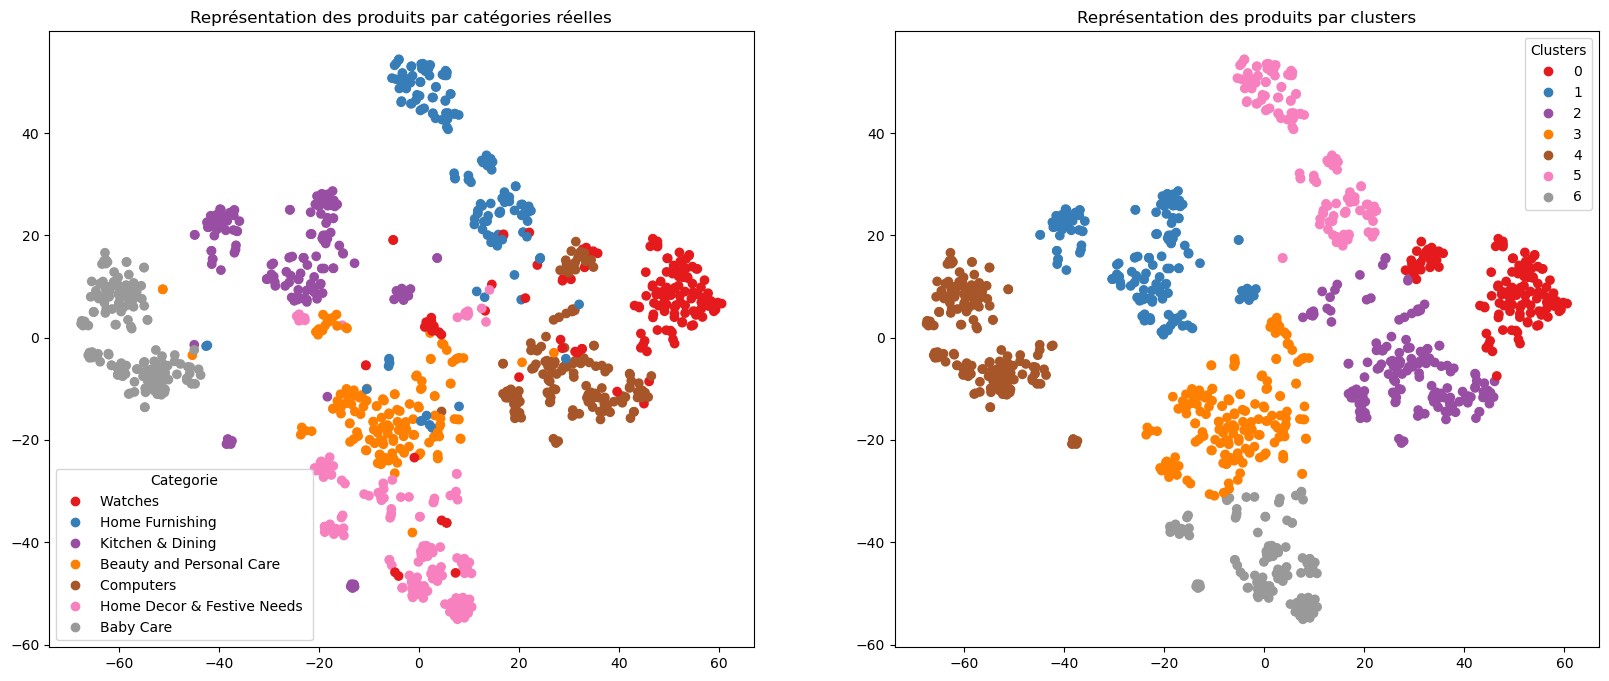

In [14]:
X_reduc = reduction_fct(embeddings, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

# <a name="C3"> III) Génération des features par Inception V3 </a>

In [16]:
from keras.applications import inception_v3, InceptionV3
from sklearn.decomposition import PCA
from tensorflow.keras.utils import load_img, img_to_array
from tqdm import tqdm
import numpy as np
from PIL import ImageOps
import warnings

warnings.simplefilter('ignore', Image.DecompressionBombWarning)

# Charger le modèle InceptionV3 pré-entraîné
model_incep = InceptionV3(
    weights="imagenet",  # Utilisation des poids pré-entraînés sur ImageNet
    input_shape=(299, 299, 3),
    include_top=False,
    pooling='avg'
)

X = []
path = "C:\\Users\\elodi\\Documents\\DS\\Flipkart\\Images\\"

print("Image pre-processing : ")

for image_num in tqdm(range(len(df["image"]))):
    # Chargement et prétraitement de l'image
    img = load_img(path + df["image"][image_num], target_size=(299, 299))
    img = ImageOps.equalize(img)  # Correction : suppression de `mask=None`
    img = img_to_array(img)  # Convertir en tableau NumPy (pas besoin de np.array)
    img = inception_v3.preprocess_input(img)  # Prétraitement spécifique à InceptionV3
    X.append(img)

# Conversion en tableau NumPy
X = np.array(X)

print("Vector creation (model.predict) : ")

# Prédiction 
Incep_features = model_incep.predict(X, batch_size=32, verbose=1)


NameError: name 'Image' is not defined

In [ ]:
X_reduc_Incep = reduction_fct(Incep_features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc_Incep, df['Categ_A'])
reduc_visu_fct(X_reduc_Incep, df['Categ_A'], labels)

# <a name="C4"> IV) Combinaison des features SBERT et Inception V3 </a>

## 1) Features bruts

In [ ]:
Feat_SBERT_Incep = np.concatenate((embeddings, Incep_features), axis=1)

In [ ]:
X_reduc = reduction_fct(Feat_SBERT_Incep, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

In [ ]:
X_reduc = reduction_fct(Feat_SBERT_Incep, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

In [ ]:
X_reduc = reduction_fct(Feat_SBERT_Incep, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

## 2) Features standardisées

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Feat_SBERT_Incep_scaled = scaler.fit_transform(Feat_SBERT_Incep)

In [ ]:
X_reduc = reduction_fct(Feat_SBERT_Incep_scaled, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

In [ ]:
X_reduc = reduction_fct(Feat_SBERT_Incep_scaled, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

In [ ]:
X_reduc = reduction_fct(Feat_SBERT_Incep_scaled, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

# <a name="C5"> V) Brève classification supervisée </a>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
X = embeddings
y = df['Categ_A']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.20, random_state=42)


model_RF = RandomForestClassifier(random_state=0)

model_RF.fit(X_train, y_train)

predictions = model_RF.predict(X_test)

cm = metrics.confusion_matrix(y_test, predictions)

conf_mat = metrics.confusion_matrix(y_test, predictions)
print(conf_mat)
print()
print(metrics.classification_report(y_test, predictions))